In [1]:
# fix import error
import sys
sys.path.append('/Users/Chris/anaconda/envs/tf/lib/python3.6/site-packages')
# make notebook full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# actual imports
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.
/Users/Chris/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
print("training data shape = " + str(train_data.shape))
print("testing data shape = " + str(test_data.shape))

training data shape = (404, 13)
testing data shape = (102, 13)


In [3]:
train_targets[0:5]

array([ 15.2,  42.3,  50. ,  21.1,  17.7])

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
# K-fold validation
import numpy as np
# of folds
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [9]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
        train_data[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
        train_targets[(i + 1) * num_val_samples:]], 
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
print('all scores ', all_scores)
print('mean of scores ', np.mean(all_scores))

all scores  [2.6883405576838126, 3.5921583270082378, 3.4051182293655851, 3.4455718545630427]
mean of scores  3.28279724216
0.350193171297


In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
        train_data[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
        train_targets[(i + 1) * num_val_samples:]], 
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

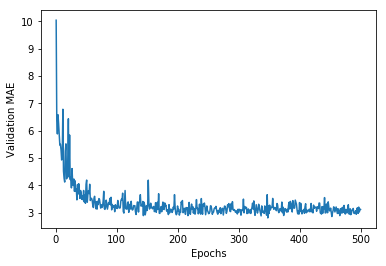

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

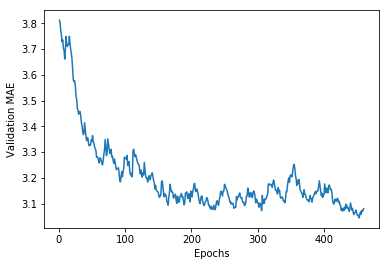

In [24]:
# upgraded plot
plt.clf()
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[40:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 817us/step


In [26]:
test_mae_score

3.902961955350988

In [ ]:
from tpot import TPOTRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

housing = load_boston()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, train_size=0.75, test_size=0.25)
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_boston_pipeline.py')

Optimization Progress:  33%|███▎      | 100/300 [00:30<01:15,  2.63pipeline/s]

Generation 1 - Current best internal CV score: 15.80691403439442


Optimization Progress:  40%|███▉      | 119/300 [00:41<01:57,  1.54pipeline/s]